# Introduction to Deep Learning

25-26 Apr 2018: [ICFO+ Theory Lecture](https://www.icfo.es/calendar2?event=3948) by [Piotr Migdał](http://p.migdal.pl/)

* Day 1: [slides (pdf)](https://www.dropbox.com/s/52wwyjnvcb820in/20180425_deep_learning_icfo.pdf?dl=0)
* Day 2: see below :)

For further materials, see:

* [Learning Deep Learning with Keras](http://p.migdal.pl/2017/04/30/teaching-deep-learning.html)
* [Data science intro for math/phys background](http://p.migdal.pl/2016/03/15/data-science-intro-for-math-phys-background.html)
* [Starting deep learning hands-on: image classification on CIFAR-10](https://blog.deepsense.ai/deep-learning-hands-on-image-classification/)

## Letter recognition

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

## Setup

### Local

* Python 3.6 with Anaconda
* Keras 2.1.4
* TensorFlow (for Keras backend)

Installing additional packages - [keras-sequential-ascii](https://github.com/stared/keras-sequential-ascii) and [livelossplot](https://github.com/stared/livelossplot).

We will use Keras 2.1.4. With [2.1.6 there might be some problems](https://github.com/keras-team/keras/issues/9621). Use `pip install -U keras==2.1.4` if needed.

### Neptune

If using on [Neptune - Machine Learning Lab](https://neptune.ml/) - create an account there. Then, create a new notebook:

* medium cpu is enough
* python 3
* keras 2.1.4
* make sure to upload this file!

![](img/neptune_notebook.png)

In [ ]:
!pip install livelossplot
!pip install keras-sequential-ascii

In [ ]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

In [ ]:
# Downloading data (112 MB). If needed, I have it on my pendrive.

## Loading packages

In [2]:
# plots
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

# data preprocessing
from scipy import io
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split

# keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization, GlobalMaxPool2D

# keras vis
from livelossplot import PlotLossesKeras
from keras_sequential_ascii import keras2ascii

/Users/pmigdal/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Data preprocessing

In [3]:
data = io.loadmat("notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32') / 255.

# shape: (sample, x, y, channel)
X = X.reshape((-1, resolution, resolution, 1))

# 3 -> [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]
Y = np_utils.to_categorical(y, 10)

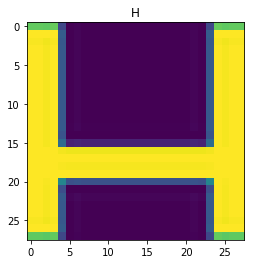

In [7]:
# looking at data; some fonts are strange
i = 15442
plt.imshow(X[i,:,:,0])
plt.title("ABCDEFGHIJ"[y[i]]);

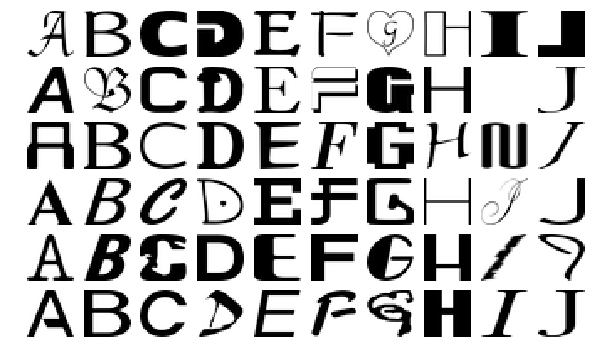

In [9]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))
for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [10]:
# splitting data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [11]:
Y_train.shape

(14979, 10)

In [12]:
Y_train[:5]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

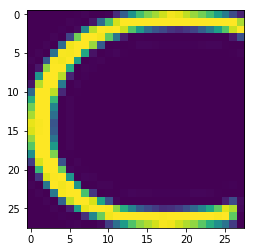

In [15]:
plt.imshow(X_train[0,:,:,0])

# Models

## Logistic regression

A simple, shallow method.

It works as follows:

* flattens input to a single vector
* multiplies by a matrix
* applies softmax

In [16]:
# creating a simple netural network
# in this case - just logistic regression

model = Sequential()
model.add(Flatten(input_shape=(resolution, resolution, 1)))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
             Flatten   ||||| -------------------         0     0.0%
                       #####         784
               Dense   XXXXX -------------------      7850   100.0%
             softmax   #####          10


In [17]:
z = np.array([-3., 6., 0., 1.5])

In [20]:
np.exp(z) / np.exp(z).sum()

array([1.21740599e-04, 9.86474295e-01, 2.44522530e-03, 1.09587395e-02])

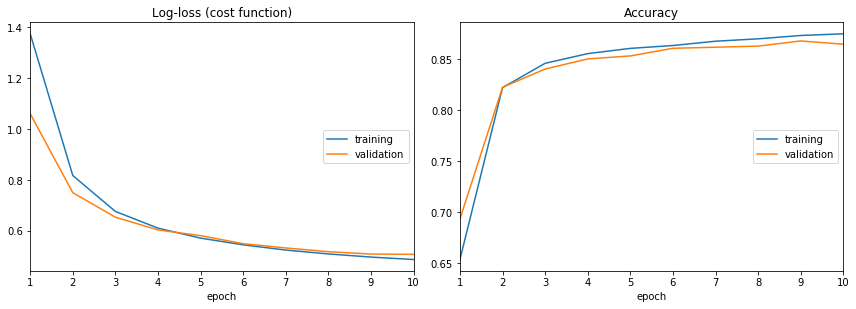

In [21]:
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=128,
          validation_data=(X_test, Y_test),
          callbacks=[PlotLossesKeras()],
          verbose=0)

In [22]:
def show_predictions(model, X=X_test, Y=Y_test, rows=8):
    # example predictions
    predictions = model.predict(X_test)

    rows = 8
    fig, axs = plt.subplots(rows, 2, figsize=(8, 1.5 * rows))
    for i in range(rows):
        ax = axs[i,0]
        idx = np.random.randint(len(X_test))
        ax.imshow(X_test[idx,:,:,0], cmap='Greys', interpolation='none')
        ax.axis('off')

        pd.Series(Y_test[idx], index=list("ABCDEFGHIJ")).plot('bar', ax=axs[i,1], ylim=[0,1], color=plt.cm.Set1(0))
        pd.Series(predictions[idx], index=list("ABCDEFGHIJ")).plot('bar', ax=axs[i,1], ylim=[0,1], color=plt.cm.Set1(1))

    plt.tight_layout()

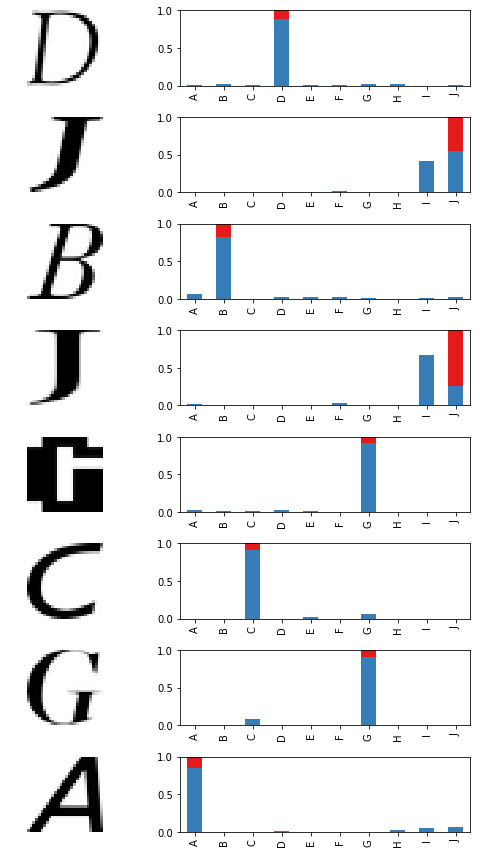

In [23]:
show_predictions(model)

## Multilayer perceptron (MLP)

An old-school network - only dense layers, sigmoid (or tanh) activation function.

In [31]:
model = Sequential()

model.add(Flatten(input_shape=(resolution, resolution, 1)))
model.add(Dense(1024, activation='tanh'))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
             Flatten   ||||| -------------------         0     0.0%
                       #####         784
               Dense   XXXXX -------------------    803840    98.7%
                tanh   #####        1024
               Dense   XXXXX -------------------     10250     1.3%
             softmax   #####          10


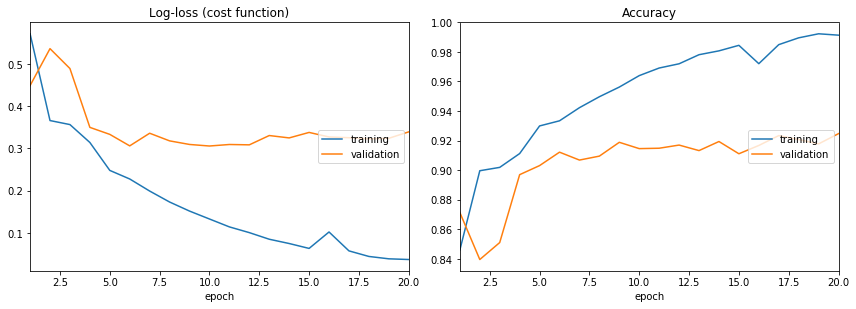

In [32]:
model.fit(X_train, Y_train,
          epochs=20,
          batch_size=128,
          validation_data=(X_test, Y_test),
          callbacks=[PlotLossesKeras()],
          verbose=1)

## Convolution

See [Image Kernels - Visually Explained](http://setosa.io/ev/image-kernels/).

Change optimizer from `sgd` to `adam`; see:

* [Why Momentum Really Works](https://distill.pub/2017/momentum/)
* [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/)
* [SGD > Adam?? Which One Is The Best Optimizer: Dogs-VS-Cats Toy Experiment](https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/)

In [36]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', padding='same',
                 input_shape=(resolution, resolution, 1)))
model.add(Flatten())
model.add(Dense(classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     0.1%
                relu   #####     28   28   16
             Flatten   ||||| -------------------         0     0.0%
                       #####       12544
               Dense   XXXXX -------------------    125450    99.9%
             softmax   #####          10


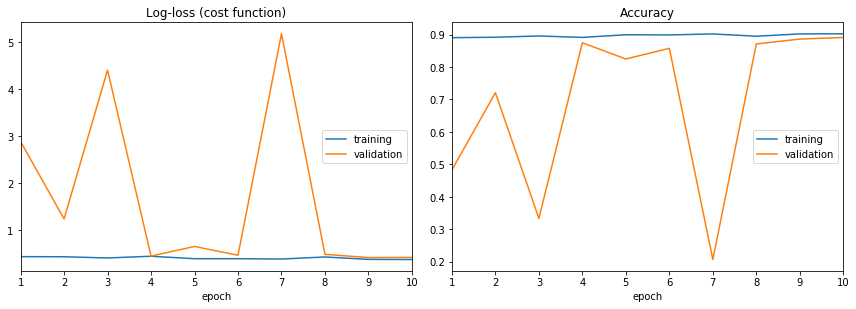

In [35]:
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=128,
          validation_data=(X_test, Y_test),
          callbacks=[PlotLossesKeras()],
          verbose=0)

## Convolution  + MaxPool

More on typical blocks in [Convolutional Neural Networks (CNNs / ConvNets)](http://cs231n.github.io/convolutional-networks/) by Andrej Karpathy.

In [37]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     0.6%
                relu   #####     26   26   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     13   13   16
             Flatten   ||||| -------------------         0     0.0%
                       #####        2704
               Dense   XXXXX -------------------     27050    99.4%
             softmax   #####          10


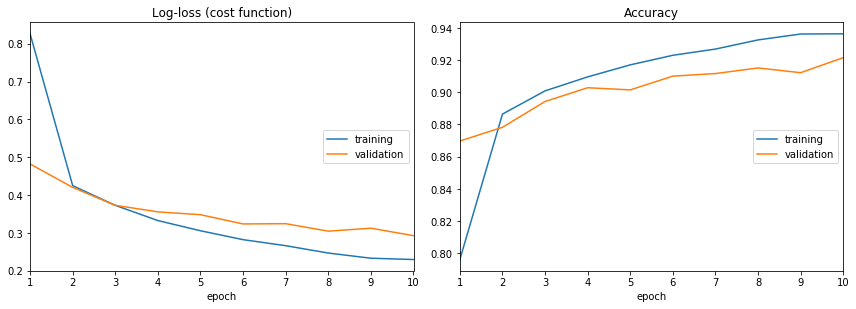

In [38]:
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=128,
          validation_data=(X_test, Y_test),
          callbacks=[PlotLossesKeras()],
          verbose=0)

### Typical ConvNet architecture

It uses hierarchical features. It allows to

* [How convolutional neural networks see the world](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html) - Keras blog
* [How neural networks build up their understanding of images](https://distill.pub/2017/feature-visualization/) - distill.pub
* [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/) - distill.pub

In [39]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     0.7%
                relu   #####     26   26   16
              Conv2D    \|/  -------------------      2320    10.8%
                relu   #####     24   24   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     12   12   16
              Conv2D    \|/  -------------------      4640    21.6%
                relu   #####     10   10   32
              Conv2D    \|/  -------------------      9248    43.0%
                relu   #####      8    8   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      4    4   32
             Flatten   ||||| -------------------         0     0.0%
                       #####         512
               Dense   XXXXX -------------------      5130    23.9%
             softma

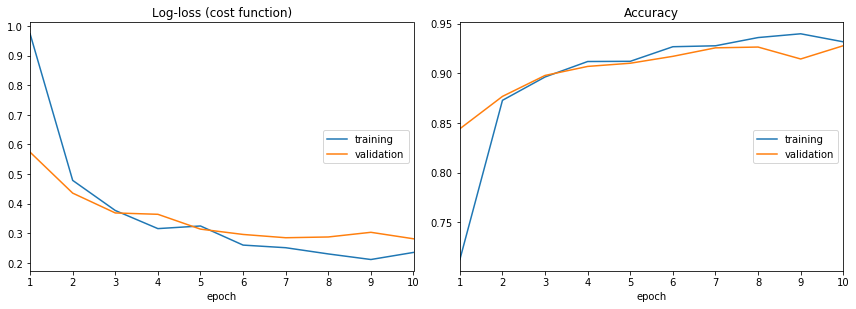

In [40]:
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=128,
          validation_data=(X_test, Y_test),
          callbacks=[PlotLossesKeras()],
          verbose=1)

### More dense layers, dropout

Usually we use 2-3 dense layers. To prevent overfitting we use **dropout**.


* Hinton et al, [Improving neural networks by preventing co-adaptation of feature detectors](https://arxiv.org/abs/1207.0580), 2012

![](img/dropout.png)

In [41]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------       160     0.3%
                relu   #####     26   26   16
              Conv2D    \|/  -------------------      2320     4.7%
                relu   #####     24   24   16
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     12   12   16
              Conv2D    \|/  -------------------      4640     9.3%
                relu   #####     10   10   32
              Conv2D    \|/  -------------------      9248    18.6%
                relu   #####      8    8   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      4    4   32
             Flatten   ||||| -------------------         0     0.0%
                       #####         512
               Dense   XXXXX -------------------     32832    65.9%
                rel

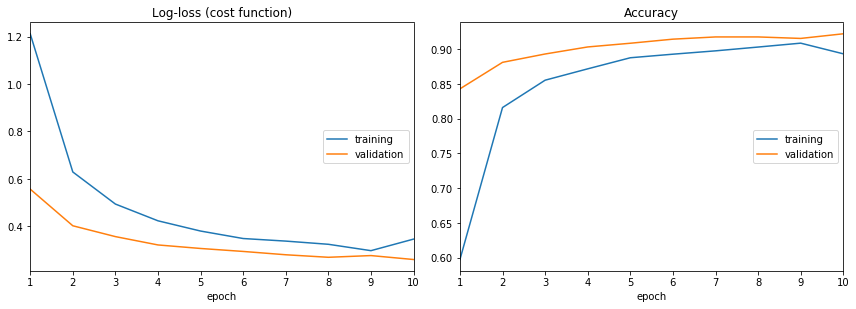

In [42]:
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=128,
          validation_data=(X_test, Y_test),
          callbacks=[PlotLossesKeras()],
          verbose=1)

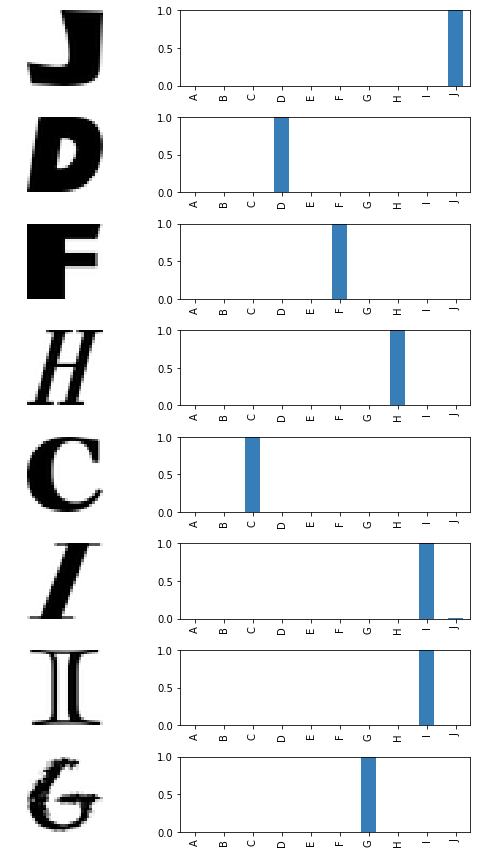

In [46]:
show_predictions(model)

## Batch normalization

Often we can speed-up training by using batch normalization. It is especially useful for deep neural networks.

* [Understanding the backward pass through Batch Normalization Layer](http://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html)
* [On The Perils of Batch Norm](https://www.alexirpan.com/2017/04/26/perils-batch-norm.html)

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

keras2ascii(model)


## Fully convolutional neural networks

Sometimes we want a network, which is fully translationally-invariant and can accept images of any size.

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu',
                 input_shape=(resolution, resolution, 1)))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D())

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(GlobalMaxPool2D())

model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

keras2ascii(model)

In [ ]:
model.fit(X_train, Y_train,
          epochs=10,
          batch_size=128,
          validation_data=(X_test, Y_test),
          callbacks=[PlotLossesKeras()],
          verbose=0)